In [ ]:
import geopandas as gpd
import numpy as np
import oggm
from oggm import utils, workflow, cfg
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import shapely.geometry as shpg
import warnings
import logging


cfg.initialize(logging_level='WARNING')

cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2023-02-17 10:28:19: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-02-17 10:28:19: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-02-17 10:28:19: oggm.cfg: Multiprocessing: using all available processors (N=12)
2023-02-17 10:28:19: oggm.cfg: PARAMS['border'] changed from `40` to `10`.
2023-02-17 10:28:19: oggm.cfg: Multiprocessing switched ON after user settings.


In [35]:
# def plot_glaciers_map(glacier_df):
#     f = plt.figure(figsize=(14, 8))
#     ax = plt.axes(projection=ccrs.PlateCarree())
#     # mark a known place to help us geo-locate ourselves 
#     ax.plot(glacier_df.POINT_LON.values, glacier_df.POINT_LAT.values, 'bo', markersize=4, transform=ccrs.Geodetic())
    
#     ax.add_feature(cartopy.feature.COASTLINE, edgecolor='gray');
#     ax.set_extent([-180, 180, -90, 90])
#     return f, ax

def plot_glaciers_map_with_RGI(glacier_df, rgi_shapefile):
    f = plt.figure(figsize=(14, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # mark a known place to help us geo-locate ourselves 
    rgi_shapefile.geometry.plot(ax=ax)
    ax.plot(glacier_df.POINT_LON.values, glacier_df.POINT_LAT.values, 'bo', markersize=4, transform=ccrs.Geodetic())
    
    ax.add_feature(cartopy.feature.COASTLINE, edgecolor='gray');
    ax.set_extent([-180, 180, -90, 90])
    return f, ax

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between one point 
    on the earth and an array of points (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371000 # Radius of earth in meters
    return c * r

# def find_subregions_for_glaciers(glacier_df, subregions_shapefile):
#     regions = []
#     # go through rows of glacier df and check if any subregion contains glacier position(Lat/lon)
#     for k, row in glacier_df.iterrows():
#         gp = shpg.Point(row.POINT_LON, row.POINT_LAT)
#         rgi_reg = []
#         for i, r in subregions_shapefile.iterrows():
#             if r.geometry.contains(gp):
#                 rgi_reg.append([r['Primary_ID'], r['Secondary_']])
#                 #break #get out of the loop as soon as a region has been found
#         if len(rgi_reg) > 1: 
#             if rgi_reg[0]==['05','01'] and rgi_reg[1]==['05','11']: # rgi region 05-01 contains 05-11
#                 regions.append(rgi_reg[1])
#             else:    
#                 print(row.GlaThiDa_ID, rgi_reg) #assert len(rgi_reg) == 1, (row.GlaThiDa_ID, rgi_reg)
#                 regions.append(rgi_reg[0])
#         else:
#             regions.append(rgi_reg[0])
#     glacier_df[['RGI_Region', 'RGI_subregion']] = regions
#     return glacier_df

# def find_regions_for_glaciers(glacier_df, regions_shapefile):
#     regions = []
#     # go through rows of glacier df and check if any subregion contains glacier position(Lat/lon)
#     for k, row in glacier_df.iterrows():
#         gp = shpg.Point(row.POINT_LON, row.POINT_LAT)
#         rgi_reg = []
#         for i, r in regions_shapefile.iterrows():
#             if r.geometry.contains(gp):
#                 rgi_reg.append(r['RGI_CODE'])
#                 #break #get out of the loop as soon as a region has been found
#         if len(rgi_reg) > 1:   
#             print(row.GlaThiDa_ID, rgi_reg) #assert len(rgi_reg) == 1, (row.GlaThiDa_ID, rgi_reg)
#         regions.append(rgi_reg[0])
            
#     glacier_df['RGI_Region'] = regions
#     return glacier_df

# def find_glaciers_in_region(glacier_df, region_shapefile):
    
#     glaciers_in_region = pd.DataFrame()
#     # go through rows of glacier df and check if any subregion contains glacier position(Lat/lon)
#     for _, row in glacier_df.iterrows():
#         gp = shpg.Point(row.POINT_LON, row.POINT_LAT)  
        
#         if region_shapefile.geometry.contains(gp).item():
#             glaciers_in_region= pd.concat([glaciers_in_region, row])

#     return glaciers_in_region




def find_RGI_IDs_for_points(glacier_df, regions=[]):
    found = []
    gdt_ids = []
    if not regions:
        regions = set()
        for n in set(glacier_df.RGI_Region.values):
            regions.add(str(n).zfill(2)) #set of regions we have to search through to find the glaciers in glacier_df
         
    for region in regions:
        print('region searched through atm: ', region)
        #get the rgi file for the region
        rgi_shp = utils.get_rgi_region_file(region, version='62') 
        rgi_df = gpd.read_file(rgi_shp)
        # subset of glaciers in the region that we want to find the rgi_id for
        glacier_sub = glacier_df.loc[glacier_df.RGI_Region == int(region)]
        # go through subset
        
        for i, row in glacier_sub.iterrows():
            gdt_ids.append(i)
            lon, lat = row.POINT_LON, row.POINT_LAT
            gp = shpg.Point(lon, lat)

            # check if glacier is in the same rgi outline as the preceding glacier
            if found: 
                last_RGI_ID_assigend=found[-1]
                s=rgi_df[rgi_df['RGIId']==last_RGI_ID_assigend]
                if  len(s.index)!=0 and s.iloc[0].geometry.buffer(0).contains(gp):
                    found.append(last_RGI_ID_assigend)
                else: found.append(find_galcierRGI_in_region(gp, lon, lat, rgi_df))    
            else:  
                found.append(find_galcierRGI_in_region(gp, lon, lat, rgi_df))      

    found_s = pd.Series(found, index=gdt_ids)
    glacier_df['RGI_ID'] = found_s
    return glacier_df

def find_galcierRGI_in_region(glacierpoint, lon, lat, rgi_df):
    #calculate distance to all glaciers in region (would be better if it was subregion only)
    rgi_df['DIST'] = haversine(lon, lat, rgi_df.CenLon.values, rgi_df.CenLat.values)
    sortrgi = rgi_df.sort_values(by='DIST')
    
    for potential_glacier_id in range(11):
        s = sortrgi.iloc[potential_glacier_id]
        if s.geometry.buffer(0).contains(glacierpoint): #is position of glacier within outline of RGI Glacier?
            return sortrgi.iloc[potential_glacier_id].RGIId
            
    # give up and set None if glacier not wihtin the outlines of the 10 nearest glaciers
    return None
    


In [3]:

cfg.PATHS['working_dir']  = 'links' #needed for oggm if we link with subregions



gtd_T = pd.read_csv('../data/glathida-3.1.0/data/TTT.csv', header=0, encoding='iso8859_15', sep=',', low_memory=False) # read the GlaThiDa data
gtd_T['GlaThiDa_ID']=gtd_T.GlaThiDa_ID.values.astype(int)

rgi_sub_shapefile = gpd.read_file('../data/GTN-G_glacier_regions/GTN-G_glacier_subregions_201707.shp') # read the RGI subregions shapefile
rgi_sub_shapefile[['Primary_ID','Secondary_']] = rgi_sub_shapefile['RGI_CODE'].str.split('-',expand=True)

rgi_shapefile = gpd.read_file('../data/GTN-G_glacier_regions/GTN-G_glacier_regions_201707.shp')  # read the RGI regions shapefile




prepare glathida measurements for linking, kicking out unwanted measurements to have fewer operations to do

In [4]:
gtd_T.head()

,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS
0,33,US,EASTON,19929999.0,NaN,1,48.767380,-121.819644,2962.0,0,NaN,NaN,NaN
1,33,US,EASTON,19929999.0,NaN,2,48.764904,-121.821909,2813.0,29,NaN,NaN,NaN
2,33,US,EASTON,19929999.0,NaN,3,48.761662,-121.825264,2598.0,41,NaN,NaN,NaN
3,33,US,EASTON,19929999.0,NaN,4,48.757063,-121.829107,2383.0,71,NaN,NaN,NaN
4,33,US,EASTON,19929999.0,NaN,5,48.753715,-121.832006,2284.0,82,NaN,NaN,NaN


Only take points with measurements from Svalbard and Jan Mayen:

In [37]:
prepro_gtd = gtd_T[gtd_T.POLITICAL_UNIT=='SJ']

dropping all measurements that dont have an uncertainty given or the position is unknown

In [38]:
prepro_gtd.dropna(subset=['POINT_LAT', 'POINT_LON'], inplace=True)


/tmp/ipykernel_983/797254649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepro_gtd.dropna(subset=['POINT_LAT', 'POINT_LON'], inplace=True)


In [39]:
prepro_gtd = prepro_gtd[prepro_gtd.THICKNESS_UNCERTAINTY.isna()]

Plot map of glaciers' positions

(<Figure size 1400x800 with 1 Axes>, <GeoAxesSubplot:>)

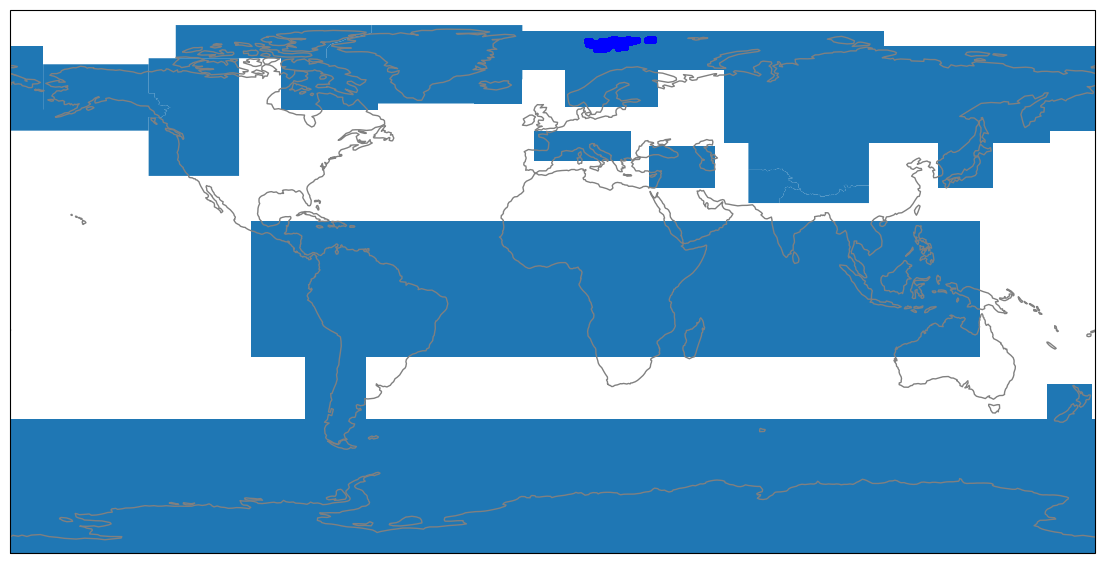

In [40]:
plot_glaciers_map_with_RGI(prepro_gtd, rgi_shapefile)

In [42]:
prepro_gtd['RGI_Region']=7
prepro_gtd_with_RGI_reg7 = find_RGI_IDs_for_points(prepro_gtd, ['07'])

region searched through atm:  07


Check on which glaciers the measurements are that could not be conneted to RGI and how many are there? 

In [80]:
grouped = prepro_gtd_with_RGI_reg7[prepro_gtd_with_RGI_reg7.RGI_ID.isna()].groupby('GLACIER_NAME')
print('Glacier name  ', 'missing measurements  ', 'total num measurements  ')
for i, glacier in grouped:
    #print(i, len(glacier))
    all = prepro_gtd_with_RGI_reg7[prepro_gtd_with_RGI_reg7.GLACIER_NAME==i]
    print(i, len(glacier), len(all))
   

Glacier name   missing measurements   total num measurements  
CHYDENIUSBREEN 38 149
INFANTFONNA 67 67
KONGSBREEN 17 287
KONGSVEGEN 3 1467
KRONEBREEN 123 165
LIESTOELBREEN 29 618
MONACOBREEN 48 1241
NATHORSTBREEN 21 46
NEGRIBREEN 127 1373
OSLOBREEN 204 1503
PAULABREEN 1 452
PENCKBREEN 17 46
RAUDFJORDBREEN 56 85
STORBREEN 3 4
SVEABREEN 146 257
VETERANEN 141 1630


In [81]:
prepro_gtd_with_RGI_reg7.dropna(subset=['RGI_ID'], inplace=True) #dropping all the measurements that couldnt be assigned to a glacier

In [82]:
prepro_gtd_linked_path = os.path.join(gtd_dir, 'RGI07_TTT_with_RGI_IDs_allyears_woUncertainty.csv')
prepro_gtd_with_RGI_reg7.to_csv(prepro_gtd_linked_path)
#prepro_gtd_with_RGI_reg7=pd.read_csv(prepro_gtd_linked_path, low_memory=False)
prepro_gtd_with_RGI_reg7.head()

,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS,RGI_Region,RGI_ID
622224,2188,SJ,BRAASVELLBREEN,19830425.0,NaN,1001281,79.262894,22.805176,24.0,93,NaN,NaN,NaN,7,RGI60-07.00025
622225,2188,SJ,BRAASVELLBREEN,19830425.0,NaN,1001282,79.263855,22.811264,25.0,93,NaN,NaN,NaN,7,RGI60-07.00025
622226,2188,SJ,BRAASVELLBREEN,19830425.0,NaN,1001283,79.264313,22.814072,27.0,93,NaN,NaN,NaN,7,RGI60-07.00025
622227,2188,SJ,BRAASVELLBREEN,19830425.0,NaN,1001284,79.265274,22.820068,31.0,96,NaN,NaN,NaN,7,RGI60-07.00025
622228,2188,SJ,BRAASVELLBREEN,19830425.0,NaN,1001285,79.265732,22.822952,35.0,101,NaN,NaN,NaN,7,RGI60-07.00025


<AxesSubplot:>

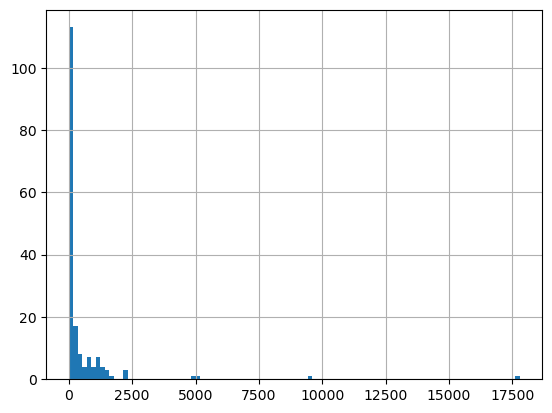

In [83]:

prepro_gtd_with_RGI_reg7.RGI_ID.value_counts().hist(bins=100)

In [ ]:
#check if saved and original are the same
#(test_saved_csv.dropna(subset=['RGI_ID']).RGI_ID==prepro_gtd_linked_RGI.dropna(subset=['RGI_ID']).RGI_ID).all()
# prepro_gtd_linked_RGI
# test_saved_csv

True